Metrics - Data Analysis

Dieses Notebook lädt TensorBoard‑Event‑Dateien eines RL‑Trainingslaufs, inspiziert die verfügbaren Metriken und erzeugt zusätzliche Visualisierungen (u. a. Boxplots), um die Ergebnisse aussagekräftiger darzustellen.



In [61]:
import os

import numpy as np
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
def load_scalars(log_dir):
    ea = event_accumulator.EventAccumulator(
        log_dir,
        size_guidance={event_accumulator.SCALARS: 0}
    )
    ea.Reload()
    scalars = ea.Tags().get('scalars', [])
    all_items = []
    for tag in scalars:
        for ev in ea.Scalars(tag):
            all_items.append({'step': ev.step,
                              'wall_time': ev.wall_time,
                              'tag': tag,
                              'value': ev.value})
    df = pd.DataFrame(all_items)
    return df


def display_available_tags(df):
    print("Verfügbare Scalar‑Tags:")
    for t in sorted(df['tag'].unique()):
        print("  •", t)
    
    return sorted(df['tag'].unique())
 
def display_train_tags(df, train_tags: list, ncols: int = 2):
    """
    Plot all specified training tags in a single figure with subplots.

    Args:
        df (pd.DataFrame): DataFrame containing 'tag', 'step', and 'value' columns.
        train_tags (list): List of tag names to plot.
        ncols (int): Number of columns in the subplot grid.
    """
    # Filter tags that exist in the DataFrame
    tags = [tag for tag in train_tags if tag in df['tag'].values]
    if not tags:
        return

    n = len(tags)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 2 * nrows), squeeze=False)

    for idx, tag in enumerate(tags):
        row, col = divmod(idx, ncols)
        subset = df[df['tag'] == tag].sort_values('step')
        ax = axes[row][col]
        ax.plot(subset['step'], subset['value'])
        ax.set_title(tag)
        ax.set_xlabel('Global Step')
        ax.set_ylabel(tag.split('/')[-1].replace('_', ' ').title())

    # Remove any unused subplots
    for idx in range(n, nrows * ncols):
        fig.delaxes(axes.flat[idx])

    fig.tight_layout()
    plt.show()



def display_eval_tags(df, eval_tags: list, ncols: int = 2):
    """
    For each evaluation tag, display summary stats and plot distribution and evolution side by side.

    Args:
        df (pd.DataFrame): DataFrame containing 'tag' and 'value' columns.
        eval_tags (list): List of tag names to analyze.
        ncols (int): Number of columns for subplot grid if extended.
    """
    for tag in eval_tags:
        if tag not in df['tag'].values:
            continue

        subset = df[df['tag'] == tag].copy()
        subset['episode'] = range(1, len(subset) + 1)

        # Display descriptive stats
        display(tag)
        display(subset[['episode', 'value']].describe())

        # Create a single figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        # Boxplot
        axes[0].boxplot(subset['value'])
        axes[0].set_title(f'Distribution of {tag}')
        axes[0].set_ylabel(tag.split('/')[-1].replace('_', ' ').title())

        # Line plot
        axes[1].plot(subset['episode'], subset['value'])
        axes[1].set_title(f'Evolution of {tag}')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel(tag.split('/')[-1].replace('_', ' ').title())

        fig.tight_layout()
        plt.show()



def display_returns_per_100_episodes(df, tag: str = 'eval/episodic_return'):
    """
    Plot the distribution of episodic returns in segments of 100 episodes in a single figure.

    Args:
        df (pd.DataFrame): DataFrame containing 'tag' and 'value' columns.
        tag (str): Tag name for episodic returns.
    """
    if tag not in df['tag'].values:
        return

    subset = df[df['tag'] == tag].copy().reset_index(drop=True)
    subset['segment'] = np.floor_divide(subset.index, 100)

    fig, ax = plt.subplots(figsize=(10, 4))
    subset.boxplot(column='value', by='segment', ax=ax, grid=False)
    ax.set_title('Eval Return pro 100 Episoden')
    ax.set_xlabel('Segment (#100 Episoden)')
    ax.set_ylabel('Return')

    plt.suptitle('')
    plt.tight_layout()
    plt.show()

## Eval baseline

In [63]:
baseline = r"runs\ALE\SpaceInvaders-v5-baseline-1-20250615_135526"
print(f"Verwende logdir: {baseline}")

Verwende logdir: runs\ALE\SpaceInvaders-v5-baseline-1-20250615_135526


In [64]:
df_base = load_scalars(baseline)
print(f"Gelesene Werte: {len(df_base):,}")

Gelesene Werte: 600


In [65]:
base_tags = display_available_tags(df_base)

Verfügbare Scalar‑Tags:
  • heuristic/episodic_length
  • heuristic/episodic_return
  • heuristic/episodic_time
  • random/episodic_length
  • random/episodic_return
  • random/episodic_time


'heuristic/episodic_length'

,episode,value
count,100.000000,100.00000
mean,50.500000,663.00000
std,29.011492,182.94024
min,1.000000,291.00000
25%,25.750000,499.75000
50%,50.500000,619.50000
75%,75.250000,792.00000
max,100.000000,1073.00000


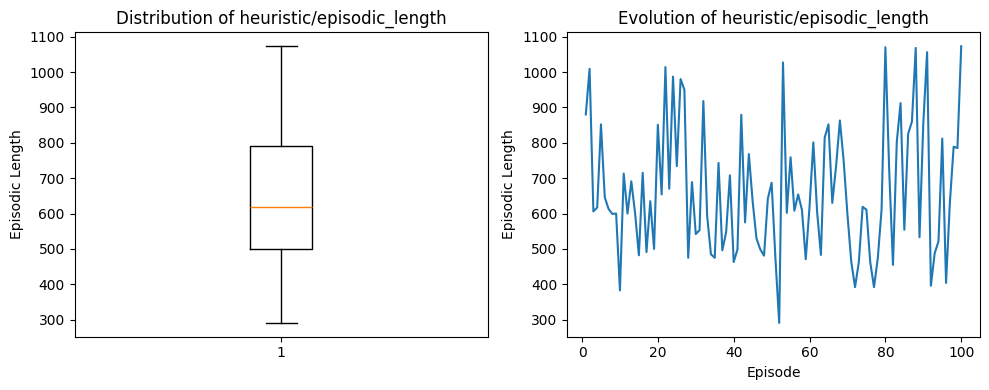

'heuristic/episodic_return'

,episode,value
count,100.000000,100.000000
mean,50.500000,265.400000
std,29.011492,105.053329
min,1.000000,85.000000
25%,25.750000,203.750000
50%,50.500000,235.000000
75%,75.250000,317.500000
max,100.000000,630.000000


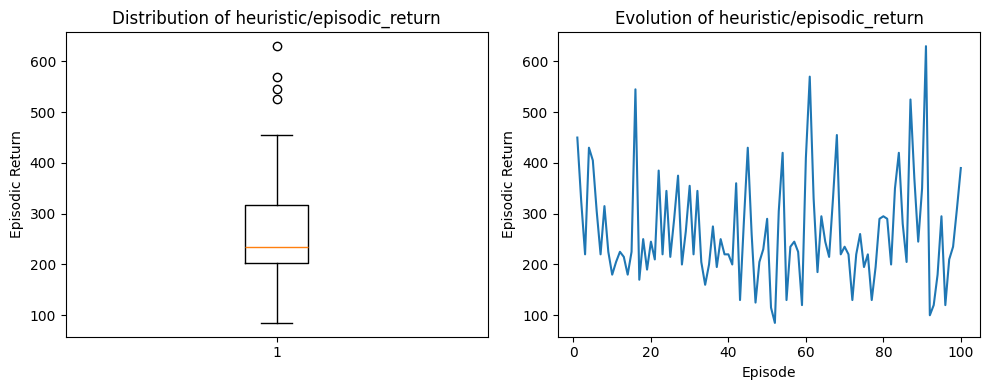

'heuristic/episodic_time'

,episode,value
count,100.000000,100.000000
mean,50.500000,0.681869
std,29.011492,0.219781
min,1.000000,0.293971
25%,25.750000,0.537170
50%,50.500000,0.652283
75%,75.250000,0.815382
max,100.000000,1.273249


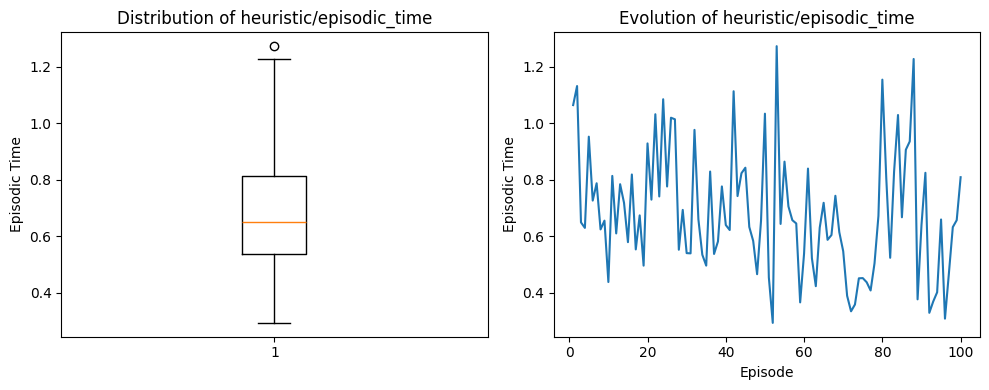

'random/episodic_length'

,episode,value
count,100.000000,100.000000
mean,50.500000,535.560000
std,29.011492,169.964959
min,1.000000,245.000000
25%,25.750000,392.750000
50%,50.500000,507.500000
75%,75.250000,648.000000
max,100.000000,951.000000


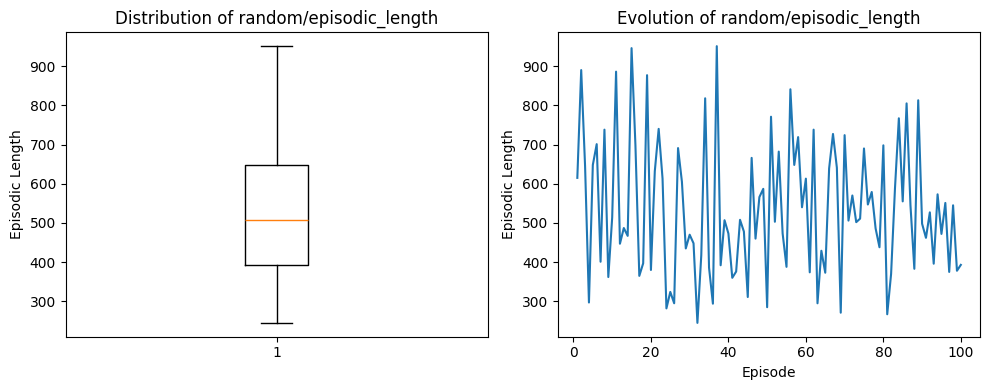

'random/episodic_return'

,episode,value
count,100.000000,100.000000
mean,50.500000,146.600000
std,29.011492,106.419885
min,1.000000,10.000000
25%,25.750000,65.000000
50%,50.500000,125.000000
75%,75.250000,195.000000
max,100.000000,665.000000


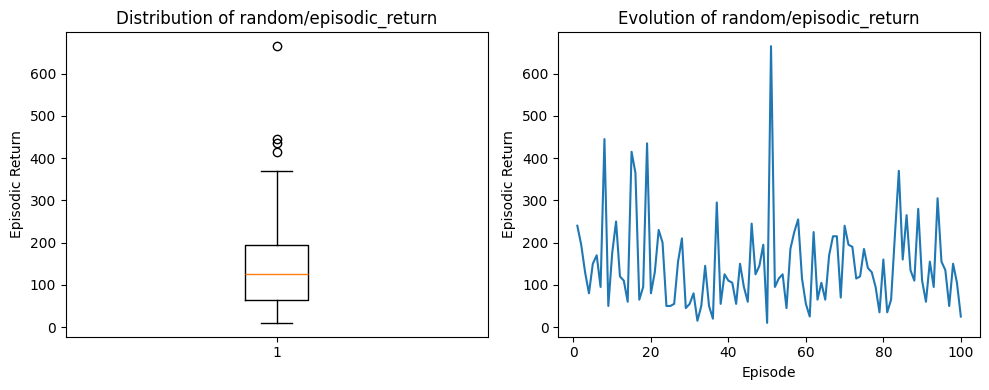

'random/episodic_time'

,episode,value
count,100.000000,100.000000
mean,50.500000,0.594032
std,29.011492,0.192682
min,1.000000,0.269295
25%,25.750000,0.454689
50%,50.500000,0.580146
75%,75.250000,0.715241
max,100.000000,1.158909


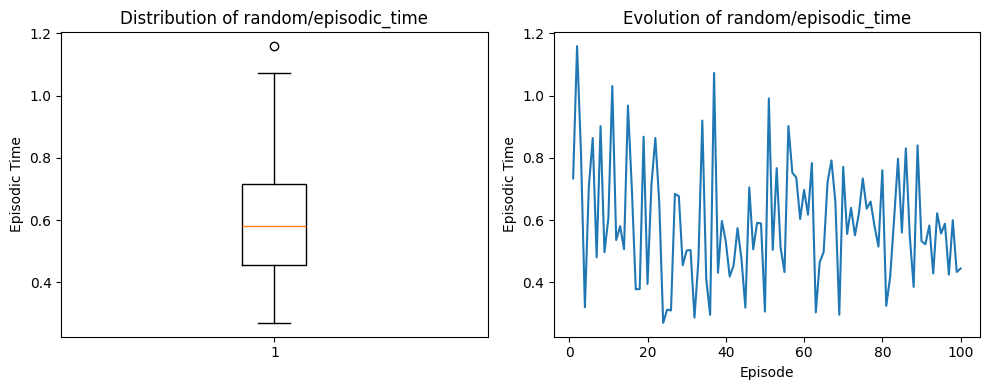

In [66]:
display_eval_tags(df_base,base_tags)

In [67]:
display_returns_per_100_episodes(df_base)

## Eval initial

In [68]:
initial = r"runs\ALE\SpaceInvaders-v5__initial__1__20250615_000342"
print(f"Verwende logdir: {initial}")

Verwende logdir: runs\ALE\SpaceInvaders-v5__initial__1__20250615_000342


In [69]:
df_init = load_scalars(initial)
print(f"Gelesene Werte: {len(df_init):,}")

Gelesene Werte: 93,264


In [70]:
init_tags = display_available_tags(df_init)

Verfügbare Scalar‑Tags:
  • charts/StepPerSecond
  • charts/learning_rate
  • eval/episodic_length
  • eval/episodic_return
  • eval/episodic_time
  • losses/approx_kl
  • losses/clipfrac
  • losses/entropy
  • losses/explained_variance
  • losses/old_approx_kl
  • losses/policy_loss
  • losses/value_loss
  • train/episodic_length
  • train/episodic_return
  • train/episodic_time


'eval/episodic_length'

,episode,value
count,100.000000,100.00000
mean,50.500000,942.54000
std,29.011492,249.96947
min,1.000000,503.00000
25%,25.750000,799.75000
50%,50.500000,902.50000
75%,75.250000,1016.75000
max,100.000000,1794.00000


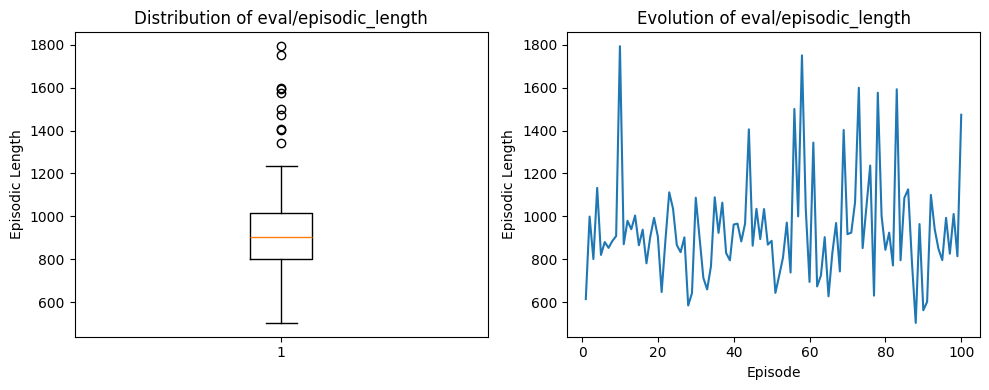

'eval/episodic_return'

,episode,value
count,100.000000,100.000000
mean,50.500000,616.650000
std,29.011492,188.921788
min,1.000000,140.000000
25%,25.750000,525.000000
50%,50.500000,577.500000
75%,75.250000,700.000000
max,100.000000,1280.000000


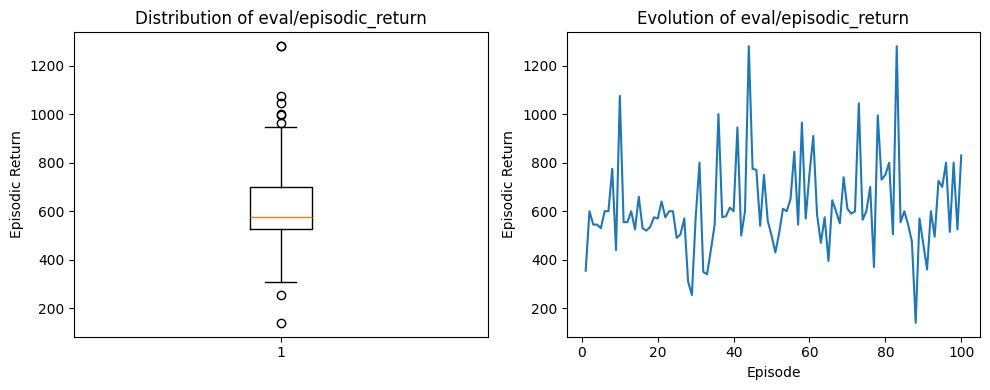

'eval/episodic_time'

,episode,value
count,100.000000,100.000000
mean,50.500000,0.617907
std,29.011492,0.161381
min,1.000000,0.334756
25%,25.750000,0.527827
50%,50.500000,0.583674
75%,75.250000,0.664647
max,100.000000,1.192714


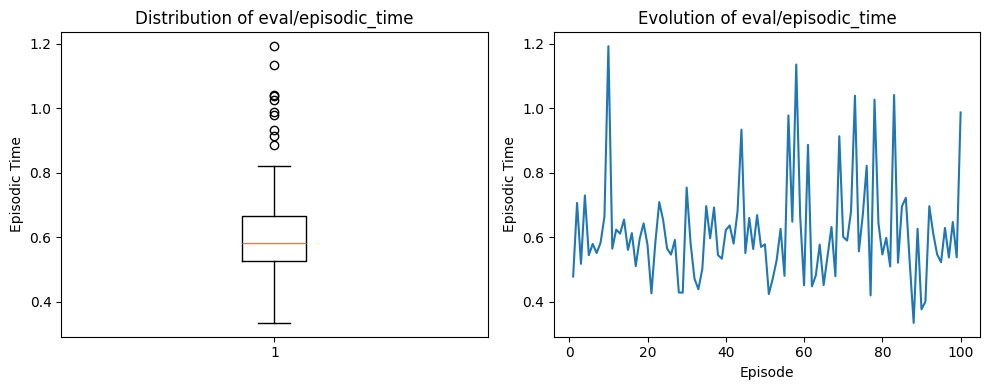

In [71]:
init_tags = [tag for tag in init_tags if tag.startswith('eval/')]

display_eval_tags(df_init, init_tags)

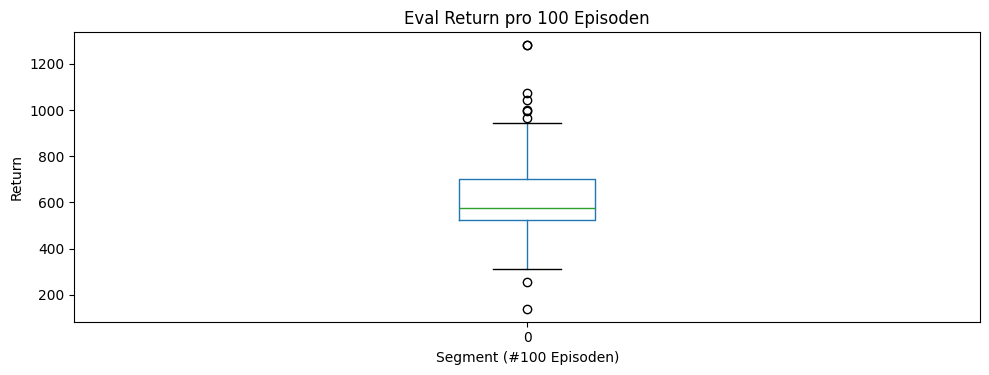

In [72]:
display_returns_per_100_episodes(df_init)

## Eval IMPALA CNN Backbone

In [73]:
impala = r"runs\ALE\SpaceInvaders-v5__impala__1__20250615_000632"
print(f"Verwende logdir: {impala}")

Verwende logdir: runs\ALE\SpaceInvaders-v5__impala__1__20250615_000632


In [74]:
df_impala = load_scalars(impala)
print(f"Gelesene Werte: {len(df_impala):,}")

Gelesene Werte: 101,037


In [75]:
impala_tags = display_available_tags(df_impala)

Verfügbare Scalar‑Tags:
  • charts/StepPerSecond
  • charts/learning_rate
  • eval/episodic_length
  • eval/episodic_return
  • eval/episodic_time
  • losses/approx_kl
  • losses/clipfrac
  • losses/entropy
  • losses/explained_variance
  • losses/old_approx_kl
  • losses/policy_loss
  • losses/value_loss
  • train/episodic_length
  • train/episodic_return
  • train/episodic_time


'eval/episodic_length'

,episode,value
count,100.000000,100.000000
mean,50.500000,845.210000
std,29.011492,194.820575
min,1.000000,402.000000
25%,25.750000,708.500000
50%,50.500000,855.000000
75%,75.250000,968.500000
max,100.000000,1574.000000


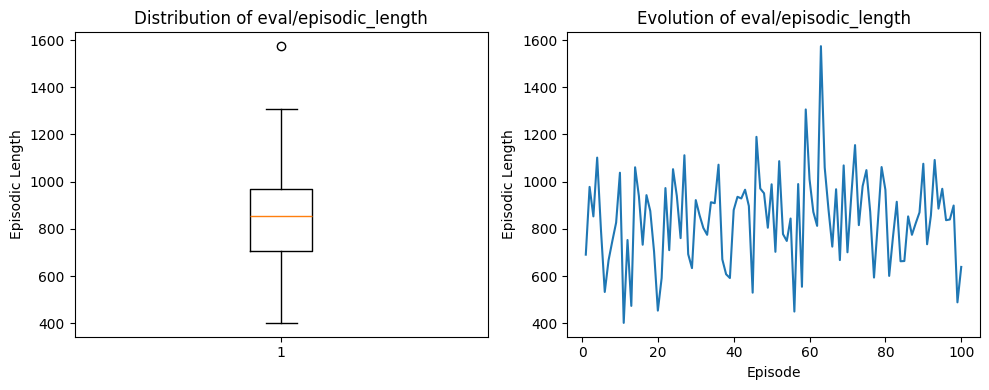

'eval/episodic_return'

,episode,value
count,100.000000,100.000000
mean,50.500000,489.500000
std,29.011492,165.670508
min,1.000000,50.000000
25%,25.750000,385.000000
50%,50.500000,505.000000
75%,75.250000,576.250000
max,100.000000,900.000000


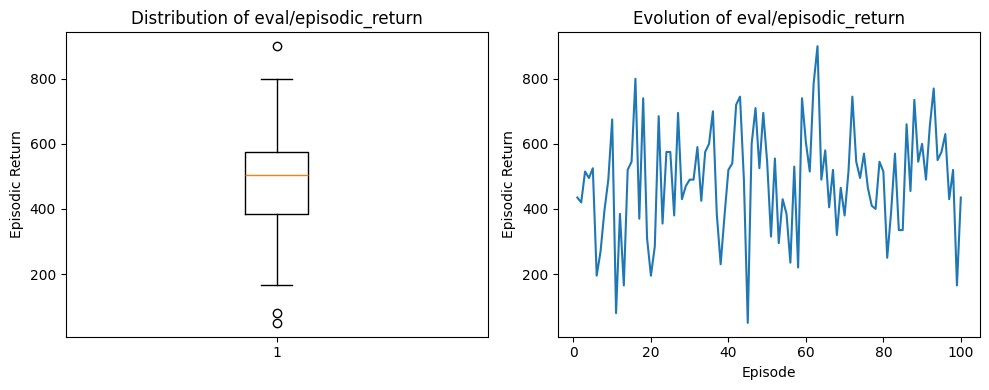

'eval/episodic_time'

,episode,value
count,100.000000,100.000000
mean,50.500000,0.539086
std,29.011492,0.122623
min,1.000000,0.252440
25%,25.750000,0.465021
50%,50.500000,0.544921
75%,75.250000,0.616500
max,100.000000,1.002458


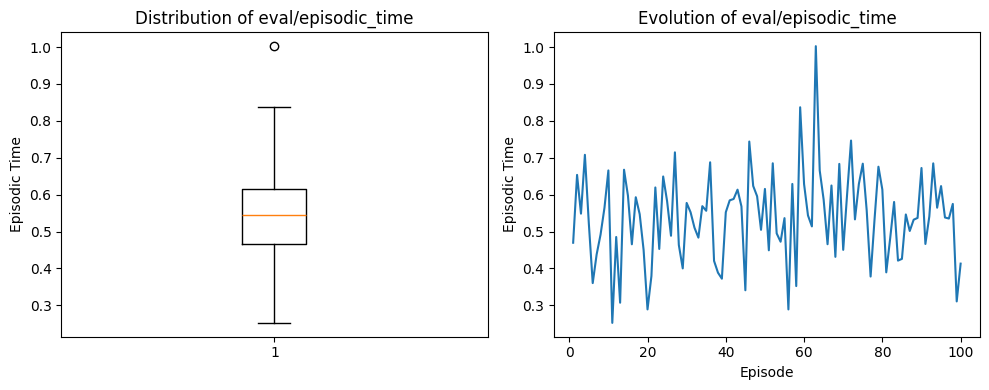

In [76]:
impala_tags = [tag for tag in impala_tags if tag.startswith('eval/')]
display_eval_tags(df_impala, impala_tags)

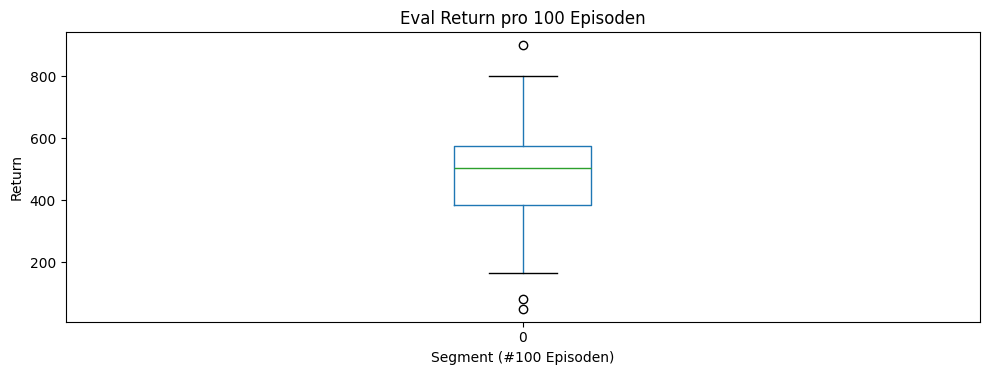

In [77]:
display_returns_per_100_episodes(df_impala)

## Eval Recurrent LSTM

In [78]:
recurrent = "runs/RecurrentPPO_5"
print(f"Verwende logdir: {recurrent}")

Verwende logdir: runs/RecurrentPPO_5


In [79]:
df_recurrent = load_scalars(recurrent)
print(f"Gelesene Werte: {len(df_recurrent):,}")

Gelesene Werte: 117,187


In [80]:
recurrent_tags = display_available_tags(df_recurrent)

Verfügbare Scalar‑Tags:
  • eval/mean_ep_length
  • eval/mean_reward
  • rollout/ep_len_mean
  • rollout/ep_rew_mean
  • time/fps
  • train/approx_kl
  • train/clip_fraction
  • train/clip_range
  • train/entropy_loss
  • train/explained_variance
  • train/learning_rate
  • train/loss
  • train/policy_gradient_loss
  • train/value_loss


'eval/mean_ep_length'

,episode,value
count,2.000000,2.000000
mean,1.500000,39.639999
std,0.707107,0.296984
min,1.000000,39.430000
25%,1.250000,39.535000
50%,1.500000,39.639999
75%,1.750000,39.744999
max,2.000000,39.849998


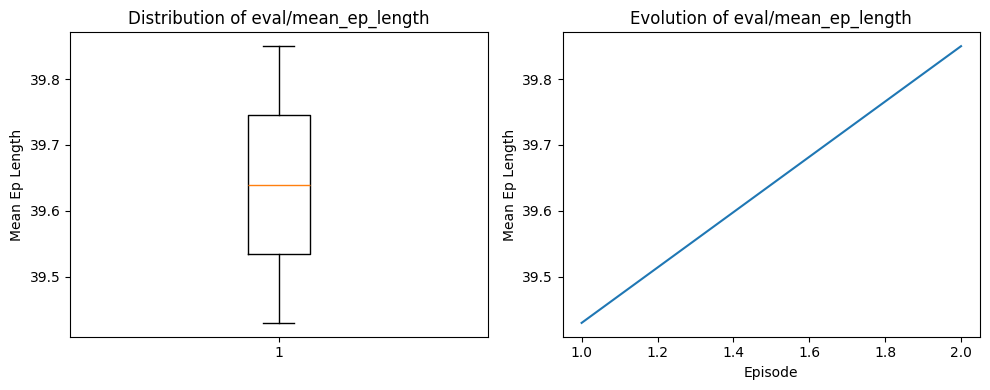

'eval/mean_reward'

,episode,value
count,2.000000,2.000000
mean,1.500000,5.675000
std,0.707107,0.021213
min,1.000000,5.660000
25%,1.250000,5.667500
50%,1.500000,5.675000
75%,1.750000,5.682500
max,2.000000,5.690000


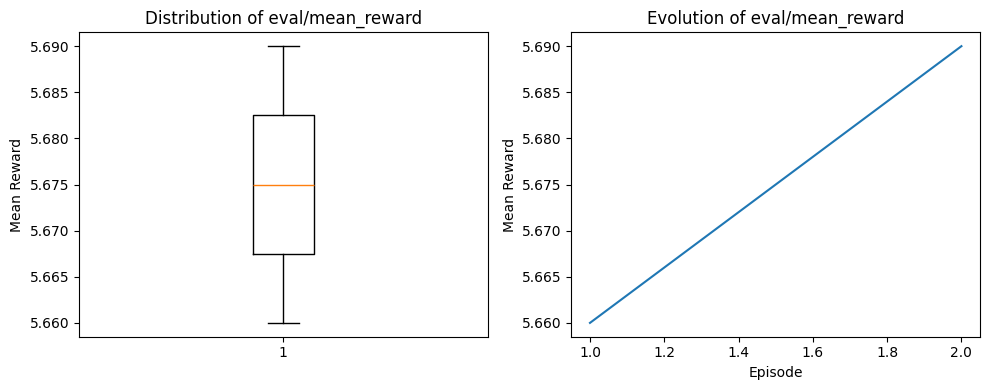

In [81]:
recurrent_tags = [tag for tag in recurrent_tags if tag.startswith('eval/')]
display_eval_tags(df_recurrent, recurrent_tags)

In [82]:
display_returns_per_100_episodes(df_recurrent)

## Eval Random Network Destillation (RND)

In [83]:
rnd = r"runs/ALE/SpaceInvaders-v5__rnd__1__20250615_000809"
print(f"Verwende logdir: {rnd}")

Verwende logdir: runs/ALE/SpaceInvaders-v5__rnd__1__20250615_000809


In [84]:
df_rnd = load_scalars(rnd)
print(f"Gelesene Werte: {len(df_rnd):,}")

Gelesene Werte: 88,736


In [85]:
rnd_tags = display_available_tags(df_rnd)

Verfügbare Scalar‑Tags:
  • charts/StepPerSecond
  • charts/learning_rate
  • eval/episodic_length
  • eval/episodic_return
  • eval/episodic_time
  • losses/approx_kl
  • losses/clipfrac
  • losses/entropy
  • losses/explained_variance_ext
  • losses/ext_value_loss
  • losses/int_value_loss
  • losses/policy_loss
  • losses/predictor_loss
  • train/episodic_length
  • train/episodic_return
  • train/episodic_time


'eval/episodic_length'

,episode,value
count,100.000000,100.00000
mean,50.500000,1557.63000
std,29.011492,284.46532
min,1.000000,479.00000
25%,25.750000,1261.75000
50%,50.500000,1645.00000
75%,75.250000,1714.25000
max,100.000000,2314.00000


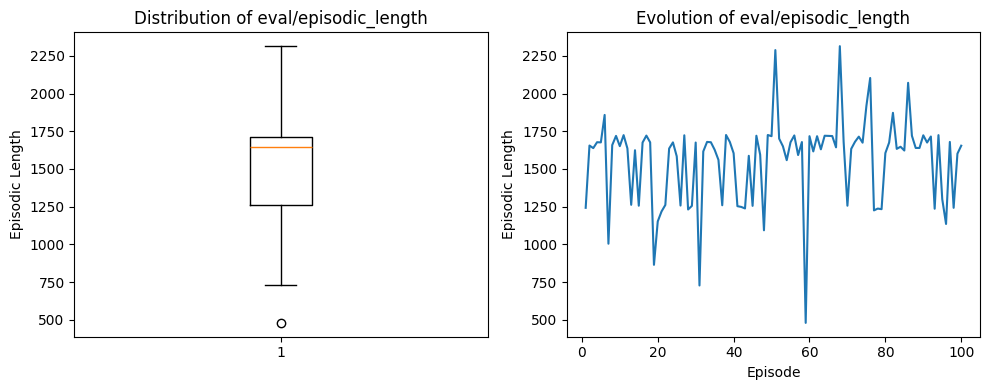

'eval/episodic_return'

,episode,value
count,100.000000,100.000000
mean,50.500000,341.750000
std,29.011492,185.776252
min,1.000000,90.000000
25%,25.750000,180.000000
50%,50.500000,332.500000
75%,75.250000,420.000000
max,100.000000,985.000000


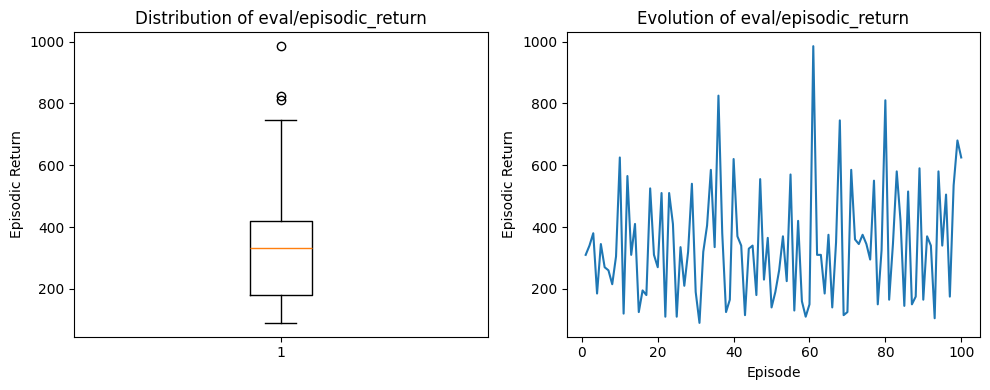

'eval/episodic_time'

,episode,value
count,100.000000,100.000000
mean,50.500000,0.970759
std,29.011492,0.174811
min,1.000000,0.290527
25%,25.750000,0.803662
50%,50.500000,1.023091
75%,75.250000,1.061787
max,100.000000,1.411122


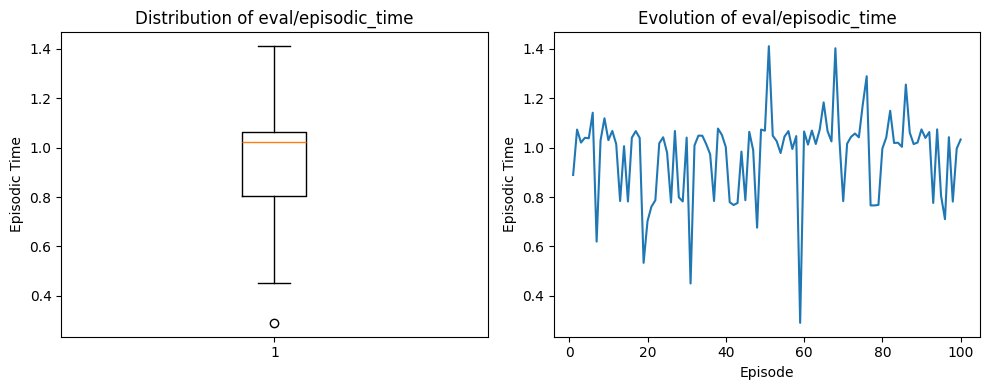

In [86]:
rnd_tags = [tag for tag in rnd_tags if tag.startswith('eval/')]
display_eval_tags(df_rnd, rnd_tags)

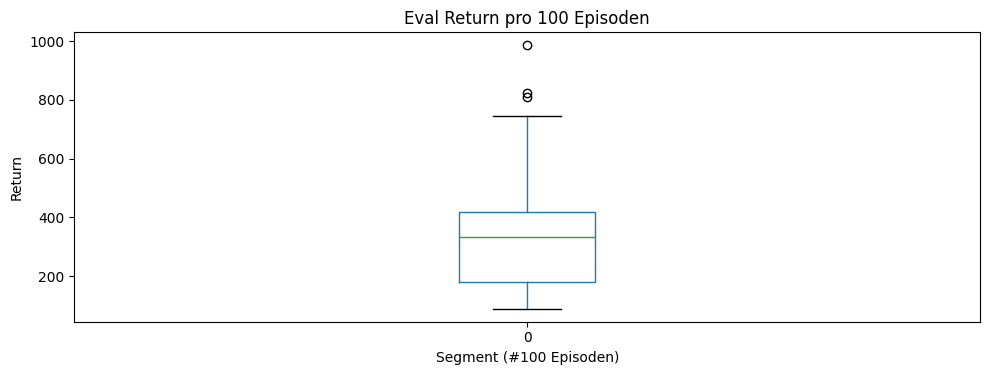

In [87]:
display_returns_per_100_episodes(df_rnd)

## Eval Hyperparameter Tuning with Optuna

In [97]:
optuna = r"runs\spaceinvaders-eval-20250615"
print(f"Verwende logdir: {optuna}")

Verwende logdir: runs\spaceinvaders-eval-20250615


In [98]:
df_optuna = load_scalars(optuna)
print(f"Gelesene Werte: {len(df_optuna):,}")

Gelesene Werte: 300


In [99]:
optuna_tags = display_available_tags(df_optuna)

Verfügbare Scalar‑Tags:
  • eval/episodic_length
  • eval/episodic_return
  • eval/episodic_time


'eval/episodic_length'

,episode,value
count,100.000000,100.000000
mean,50.500000,971.570000
std,29.011492,207.956836
min,1.000000,560.000000
25%,25.750000,867.750000
50%,50.500000,925.000000
75%,75.250000,1006.250000
max,100.000000,1644.000000


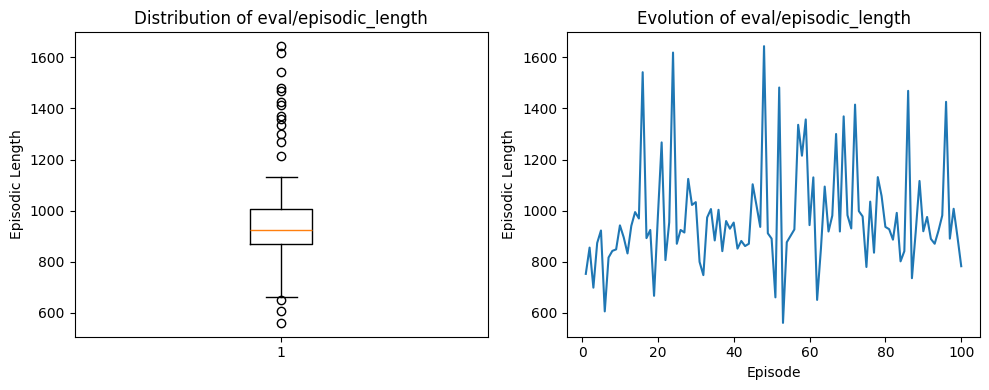

'eval/episodic_return'

,episode,value
count,100.000000,100.000000
mean,50.500000,676.000000
std,29.011492,172.461385
min,1.000000,335.000000
25%,25.750000,573.750000
50%,50.500000,605.000000
75%,75.250000,775.000000
max,100.000000,1220.000000


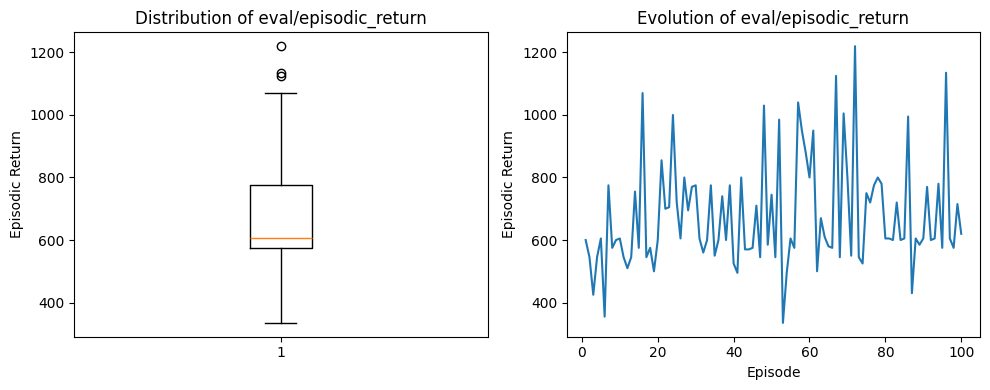

'eval/episodic_time'

,episode,value
count,100.000000,100.000000
mean,50.500000,0.565315
std,29.011492,0.126064
min,1.000000,0.327851
25%,25.750000,0.496086
50%,50.500000,0.533545
75%,75.250000,0.582564
max,100.000000,0.957814


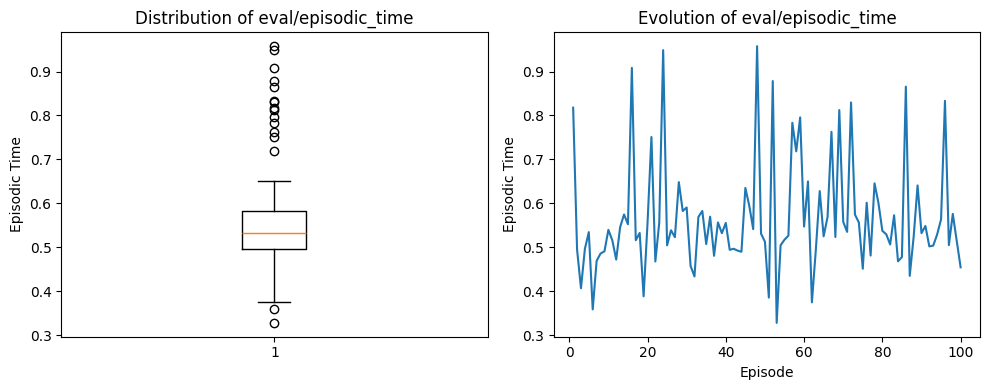

In [100]:
optuna_tags = [tag for tag in optuna_tags if tag.startswith('eval/')]
display_eval_tags(df_optuna, optuna_tags)

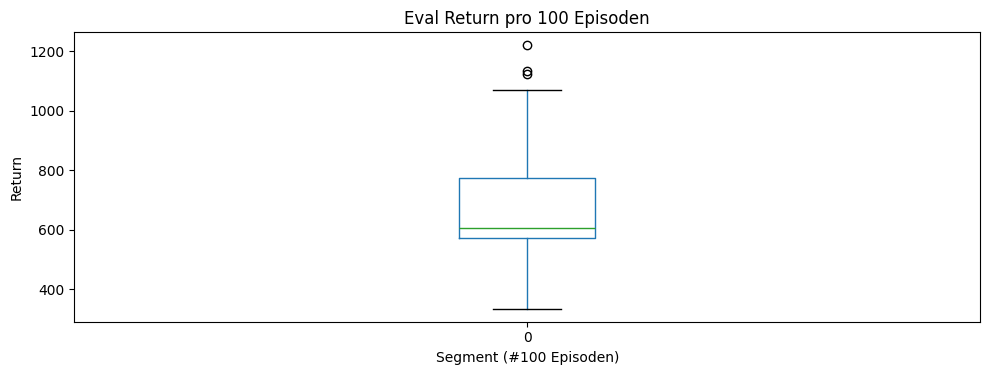

In [103]:
display_returns_per_100_episodes(df_optuna)

In [94]:
import torch 
model_path = r"runs\ALE\SpaceInvaders-v5__hp-optuna__1__20250615_100646/hp-optuna.cleanrl_model"
checkpoint = torch.load(model_path, map_location='cpu')

# Falls der Checkpoint ein Dict mit Key 'model' ist, nimm dessen Inhalt,
# sonst gehe davon aus, dass es direkt ein state_dict ist.
state_dict = checkpoint.get('model', checkpoint)

# Parameter auslesen
param_shapes = {name: tuple(param.shape) for name, param in state_dict.items()}
print(param_shapes)

{'network.0.weight': (32, 4, 8, 8), 'network.0.bias': (32,), 'network.2.weight': (64, 32, 4, 4), 'network.2.bias': (64,), 'network.4.weight': (64, 64, 3, 3), 'network.4.bias': (64,), 'network.7.weight': (512, 3136), 'network.7.bias': (512,), 'actor.weight': (6, 512), 'actor.bias': (6,), 'critic.weight': (1, 512), 'critic.bias': (1,)}
